# LANL earthquake prediction - recurrent analysis

# Introduction
The purpose of this notebook is to forecast **when** an earthquake will occur.  Time-series signal data (from https://www.kaggle.com/c/LANL-Earthquake-Prediction) were taken from an experiment conducted on a classic laboratory earthquake model, specifically the acoustic data input signal used to predict the time before the nest laboratory earthquake.  The data is grouped into two columns called '***acoustic data***' and '***time to failure***'.  

Over 600 million data points were collected in this experiment to yield over 9 GB of data.  This notebook is part of a three notebook series to analyze the time to failure given from seismic data.  This notebook focuses on leaving the input data in its raw form (apart from scaling) and using a recurrent model to predict the time to failure for the next earthquake.  

The kaggle competition looks at the **Mean Absolute Error** between the actual and predicted time to failure of the final data point in a given chunk.

# Load libraries and frameworks

The following packages are loaded to aid in the analysis.

In [0]:
# System functions
import os
from io import StringIO
import csv
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tqdm
from datetime import datetime
import time

# Math and data analysis
import pandas as pd
import numpy as np
import math
from random import shuffle
from sklearn.metrics import mean_absolute_error

# Visualizations
import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('default')
from matplotlib import pyplot

# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Machine learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, LSTM, GRU
from tensorflow.keras.layers import CuDNNGRU, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Input, Activation
from tensorflow.keras.optimizers import Adam

# Set random seeds
np.random.seed(42)
# rn.seed(42)
tf.set_random_seed(42)

In [0]:
# For plotting purposes
label_font = {'size': 14}
tick_font = {'size': 14}

# Exploratory data analysis

## If using colab use this section to get the data from Kaggle

In [0]:
# import data using kaggle
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shahroberto","key":"51d0b7ea35d3ef2fd927ad63a7af85c5"}'}

In [0]:
!cp kaggle.json ~/.kaggle/

In [6]:
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c LANL-Earthquake-Prediction
!ls

  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 12.8MB/s]
 93% 225M/242M [00:01<00:00, 143MB/s]
100% 242M/242M [00:01<00:00, 139MB/s]
 99% 2.01G/2.03G [00:18<00:00, 98.0MB/s]
100% 2.03G/2.03G [00:18<00:00, 119MB/s] 
kaggle.json  sample_data  sample_submission.csv  test.zip  train.csv.zip


In [7]:
!unzip /content/train.csv.zip

Archive:  /content/train.csv.zip
  inflating: train.csv               


In [0]:
# # unzip files into folder
# !unzip /content/test.csv.zip -d /content/LANL_te

In [9]:
# Load keras model trained on all data (if training has been done)
if not(os.path.isfile('/content/final_GRU_model.h5')):
  files.upload()
deep_GRU = load_model('/content/final_GRU_model.h5')

Saving final_GRU_model.h5 to final_GRU_model.h5
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


## Global variables
Global variables used throughout the analysis.  TOTAL_ROWS and CHUNK_SIZE are variables used to process the data in chunks since the amount of data exceeds the RAM on the system.  TRAIN_SIZE and VAL_SIZE are determined to be 70% and 30% of the data respectively.  The train and validation data are kept in sequential order, and not shuffled, because the recurrent models that will analyze the signals are time dependant and shuffling will lose information.  AC_MAX/MIN and TF_MAX/MIN are the min and max values in the respective columns and will be used to customize the MinMaxScaler used to scale the data.

In [0]:
# Path locations to save and load data
RAW_PATH_TR = "/content/train.csv"
PROCESS_PATH_TR = "/content/processed_tr.csv"
OUTPUT_DIR = './{date:%Y-%m-%d_%H:%M:%S}/'.format(date=datetime.now())
if not os.path.exists(OUTPUT_DIR):
  os.makedirs(OUTPUT_DIR)
  
TOTAL_ROWS = 629_145_480 # For all rows: 629_145_480
CHUNK_SIZE = 150_000
NUM_CHUNKS = TOTAL_ROWS//CHUNK_SIZE
BATCH_SIZE = 500
EPOCHS = 1
EPSILON = 0.00005
WINDOW_SIZE = 5

DATA_SIZE = TOTAL_ROWS - (WINDOW_SIZE + 1) # Size of windowed data
TRAIN_SIZE = int(0.7 * DATA_SIZE)
VAL_SIZE = DATA_SIZE - TRAIN_SIZE

# min and max values of the dataset for the scalar
AC_MIN = -5515
AC_MAX = 5444
TF_MIN = 9.5503965e-05
TF_MAX = 16.1074

## Visualize train data
The first 100_000_000 instances of the training data will be illustrated.  Notice that the base of the sawtooth for the time to failure corresponds to one single earthquake.

In [11]:
# Visualize the dataframe
visual_df = pd.read_csv(
    RAW_PATH_TR,
    nrows=10,
)

visual_df.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [0]:
def plot_overlayed(
    dat1, 
    dat2, 
    title='Acoustic data and time to failure', 
    x_axis='Time to failure', 
    y_axis='Acoustic',
    leg1='Acoustic data',
    leg2='Time to failure',):
  
    fig, ax1 = plt.subplots(figsize=(12, 4))
    plt.title(title,fontdict=label_font)
    plt.plot(dat1, color='deepskyblue', linewidth=1)
    ax1.set_ylabel(y_axis,fontdict=label_font)
    plt.legend([leg1], loc=1)
    ax2 = ax1.twinx()
    plt.plot(dat2, color='orange', linewidth=1)
    ax2.set_ylabel(x_axis,fontdict=label_font)
    plt.legend([leg2], loc=2)
    plt.grid(True)
    plt.tight_layout()

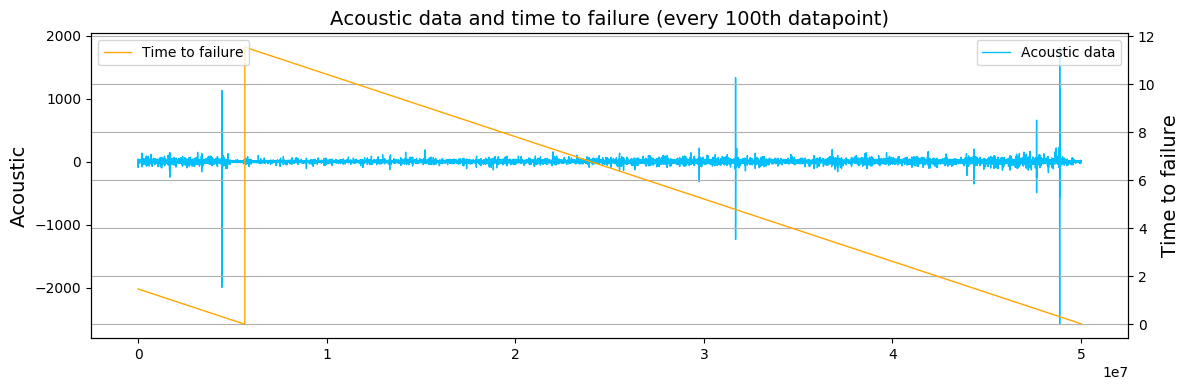

In [13]:
raw_df = pd.read_csv(
    RAW_PATH_TR,
    dtype={'acoustic_data': np.float32, 'time_to_failure': np.float32},
    chunksize=50_000_000,
    nrows=50_000_000,
)

for chunk in raw_df:
  plot_overlayed(
      chunk.iloc[0:-1:100,0],
      chunk.iloc[0:-1:100,1],
      title="Acoustic data and time to failure (every 100th datapoint)",
  )

## Preprocess train data
This section imports the training data using a memory map and transforms the data, chunk by chunk, into data that is ready to input into the machine learning model.  

First, the data is scaled using the scaler with the max and min parameters defined in the global variable inputs.  Next, the data is processed using a sliding window which is typical for time-series problems.  One row in the dataframe being written to the disk consists of the ttf in the final column and the (window_size) previous acoustic points.  This dataframe is used to train the recurrent model.

In [0]:
# # Create function that writes a window_size amount of inputs for 1 output
# # to a csv file to later be used in training
def create_windowed_inputs(df):
  window_size = WINDOW_SIZE - 1

  # No sliding occurs and the df is the same as the raw data
  if window_size == 0:
    return df 
  else:
    if (type(df) == 'pandas.core.frame.DataFrame'):
      # Copy the dataframe
      if df.shape[1] > 1: # check for a ttf column
        series_s = df.acoustic_data.copy()
        series_ttf = df.time_to_failure
    else:
      series_s = df.copy()
    # Concatenate the windowed df with the shifted series  
    for i in range(window_size):
      df = pd.concat(
          [df.acoustic_data, series_s.shift(-(i+1))], 
          axis=1,
      )
    if (type(df) == 'pandas.core.frame.DataFrame'):
      if df.shape[1] > 1: # check for a ttf column
        df = pd.concat(
                [df, series_ttf], 
                axis=1,
             )
    # Drop the Nan values
    df.dropna(axis=0, inplace=True) 
    return df

In [0]:
def preprocess_df(scaler, in_f=RAW_PATH_TR, out_f=PROCESS_PATH_TR):
  # Read df in chunks for efficient RAM
  raw_df = pd.read_csv(
      in_f,
      dtype={'acoustic_data': np.float32, 'time_to_failure': np.float32},
      chunksize=CHUNK_SIZE,
      nrows=TOTAL_ROWS,
  )
  
  for i, chunk in enumerate(raw_df):
    i = i+1
    if (i == 1) or (i % 10 == 0):
        print('Processing chunk {} out of {}'.format(i, NUM_CHUNKS))
        
    if chunk.shape[1] > 1:
      scaled_val = scaler.transform(chunk)
      d = {'acoustic_data': scaled_val[:,0], 'time_to_failure': scaled_val[:,1]}
    else:
      scaled_val = scaler.transform(chunk['acoustic_data'])
      d = {'acoustic_data': scaled_val}   
      
    result = pd.DataFrame(d)
    
    if i > 1:
      result = pd.concat([last_rows, result]).reset_index(drop = True) 
          
    last_rows = result[-(WINDOW_SIZE-1):]    
       
    windowed_result = create_windowed_inputs(result)    
    
    if i == 1:      
      windowed_result.to_csv(out_f, index=False, header=True, mode='a')    
    else:
      windowed_result.to_csv(out_f, index=False, header=False, mode='a')          

In [16]:
# Declare the scaler and fit to the df
scaler = MinMaxScaler()

# Set the bounds of the scaler to the data [min,max] from Kaggle
scaler.fit([[AC_MIN, TF_MIN],
           [AC_MAX, TF_MAX]])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [17]:
# Process the dataframe
preprocess_df(scaler)

Processing chunk 1 out of 4194
Processing chunk 10 out of 4194
Processing chunk 20 out of 4194
Processing chunk 30 out of 4194
Processing chunk 40 out of 4194
Processing chunk 50 out of 4194
Processing chunk 60 out of 4194
Processing chunk 70 out of 4194
Processing chunk 80 out of 4194
Processing chunk 90 out of 4194
Processing chunk 100 out of 4194
Processing chunk 110 out of 4194
Processing chunk 120 out of 4194
Processing chunk 130 out of 4194
Processing chunk 140 out of 4194
Processing chunk 150 out of 4194
Processing chunk 160 out of 4194
Processing chunk 170 out of 4194
Processing chunk 180 out of 4194
Processing chunk 190 out of 4194
Processing chunk 200 out of 4194
Processing chunk 210 out of 4194
Processing chunk 220 out of 4194
Processing chunk 230 out of 4194
Processing chunk 240 out of 4194
Processing chunk 250 out of 4194
Processing chunk 260 out of 4194
Processing chunk 270 out of 4194
Processing chunk 280 out of 4194
Processing chunk 290 out of 4194
Processing chunk 300 

In [18]:
# Visualize the dataframe
visual_processed_df = pd.read_csv(
    PROCESS_PATH_TR,
    nrows=10,
)

visual_processed_df.head()

,acoustic_data,acoustic_data.1,acoustic_data.2,acoustic_data.3,acoustic_data.4,time_to_failure
0,0.504334,0.503787,0.503969,0.503696,0.503969,0.091201
1,0.503787,0.503969,0.503696,0.503969,0.503969,0.091201
2,0.503969,0.503696,0.503969,0.503969,0.504061,0.091201
3,0.503696,0.503969,0.503969,0.504061,0.503878,0.091201
4,0.503969,0.503969,0.504061,0.503878,0.502783,0.091201


## Create and train model (skip if model was loaded earlier)
Many architectures and hyperparameters were explored for this analysis, however, only the final result is shown.  

The time-series data is chosen to be modelled using a recurrent model in this notebook to complement the other notebooks in the series which analyze CNN and DNNs on compressed data sets.  The data is this analysis is kept in its raw form, only being scaled to fit in (0, 1).  It was also decided to use an LSTM model because it can retain more information over a sequence.  Since the number of data points in the signal exceeds 600 million, it is decided to use a GRU model because it is shown to perform as well as the LSTM but much faster. 

The model architecure started much deeper than the final model.  It is noticed that the model very quickly overfit the univariate data so the architecture was reduced to a single GRU layer.  Much work is done to prevent overfitting and vanishing gradients.  A dropout layer of 70% dropout rate is added after the activation ReLU function which is added after the a batch normalization layer.  The cell output is fed into a dense layer with one output that is used to predict the time to failure.

In [0]:
def build_GRU_model():
  learn_rate = 1e-8
  num_units = 24
  
  model = Sequential()
  
  model.add(CuDNNGRU(
      units=num_units,
      input_shape=(WINDOW_SIZE, 1),
      name='GRU_1'
  ))  
  model.add(BatchNormalization(epsilon=EPSILON, name='batch_normalization_1'))  
  model.add(Activation('relu', name='ReLU_1'))
  model.add(Dropout(0.7, name='dropout_1'))
  model.add(Dense(1, name='dense_1'))
  model.add(Activation('linear', name='linear'))
  
  model.summary()
  
  model.compile(optimizer=Adam(lr=learn_rate), loss="mae")
  
  return model

In [0]:
# Function to plot loss and duration
def summarize_epoch(duration, losses, chunk_no):
  print("Chunk no. {}".format(chunk_no),
        "\nDuration of chunk: {:.5f}".format(duration))
  fig, ax = plt.subplots(figsize=(5, 3))
  plt.title('Loss over batches', fontdict=label_font)
  plt.plot(losses, color='deepskyblue', linewidth=1)
  plt.grid(False)
  plt.tight_layout()
  plt.savefig(OUTPUT_DIR + "losses_" + str(chunk_no) + ".png")
  plt.show()
  plt.close()

In [0]:
def train_model(model, start_point=0):
  losses = []
  
  num_chunks = int(TRAIN_SIZE/CHUNK_SIZE)
  # Read df in chunks for efficient RAM
  processed_df = pd.read_csv(
      PROCESS_PATH_TR,
      chunksize=CHUNK_SIZE,
      skiprows=[start_point],
      nrows=TRAIN_SIZE,
  )
  
  for epoch in range(EPOCHS):
    epoch += 1
    # start_time = time.time() 
    print('-'*20, 'Epoch ', epoch, '-'*20)    
    k = 0 
    for chunk in processed_df: 
      k += 1
      if k <= num_chunks:
        if k == 1 or k % 50 == 0:
          print('Processing chunk {}/{}...'.format(k, num_chunks))
        start_time = time.time()
        X = chunk.iloc[:, :-1].values
        y = chunk.iloc[:, -1].values
        # reshape to batch_size, n_steps, n_inputs
        X = np.reshape(X, (X.shape[0], X.shape[1], 1)) 
        for i in range(int(CHUNK_SIZE//BATCH_SIZE)):
          loss = model.train_on_batch(X[i*BATCH_SIZE:(i+1)*BATCH_SIZE,:,:],
                                      y[i*BATCH_SIZE:(i+1)*BATCH_SIZE])
          losses.append(loss)        

        if k % 250 == 0:
          summarize_epoch(time.time()-start_time, losses, k)
          print("saving model...")
          model.save("LANL-e" + str(epoch) + "-" + str(k) + '.h5')       

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GRU_1 (CuDNNGRU)             (None, 24)                1944      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24)                96        
_________________________________________________________________
ReLU_1 (Activation)          (None, 24)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
_________________________________________________________________
linear (Activation)          (None, 1)                 0         
Total params: 2,065
Trainable params: 2,017
Non-trainable params: 48
_________________________________________________________________
-------

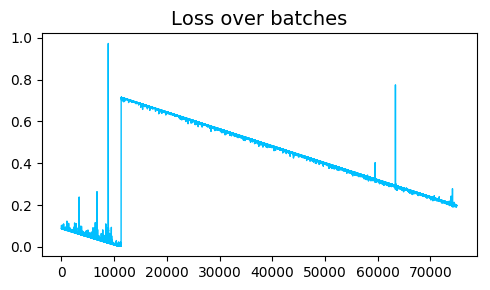

saving model...
Processing chunk 300/2936...
Processing chunk 350/2936...
Processing chunk 400/2936...
Processing chunk 450/2936...
Processing chunk 500/2936...
Chunk no. 500 
Duration of chunk: 1.80442


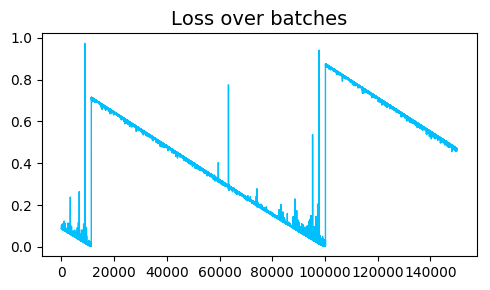

saving model...
Processing chunk 550/2936...
Processing chunk 600/2936...
Processing chunk 650/2936...
Processing chunk 700/2936...
Processing chunk 750/2936...
Chunk no. 750 
Duration of chunk: 1.81678


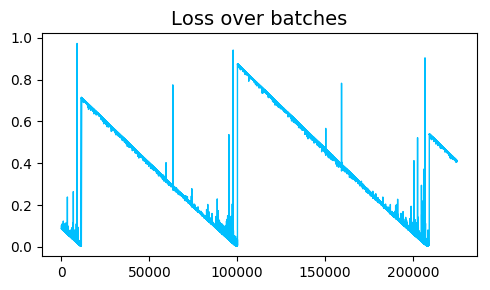

saving model...
Processing chunk 800/2936...
Processing chunk 850/2936...
Processing chunk 900/2936...
Processing chunk 950/2936...
Processing chunk 1000/2936...
Chunk no. 1000 
Duration of chunk: 1.81209


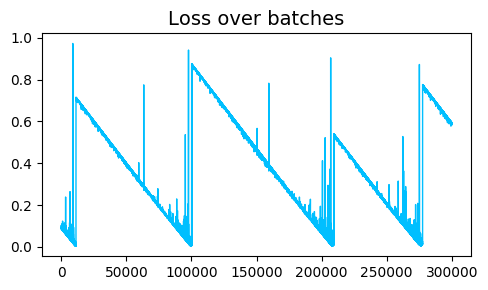

saving model...
Processing chunk 1050/2936...
Processing chunk 1100/2936...
Processing chunk 1150/2936...
Processing chunk 1200/2936...
Processing chunk 1250/2936...
Chunk no. 1250 
Duration of chunk: 1.75567


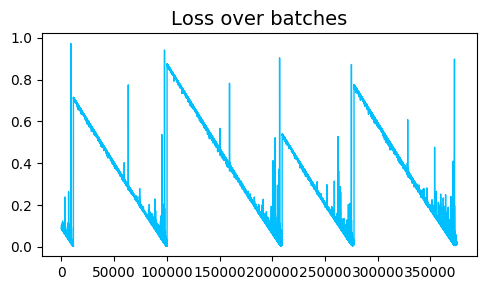

saving model...
Processing chunk 1300/2936...
Processing chunk 1350/2936...
Processing chunk 1400/2936...
Processing chunk 1450/2936...
Processing chunk 1500/2936...
Chunk no. 1500 
Duration of chunk: 1.79873


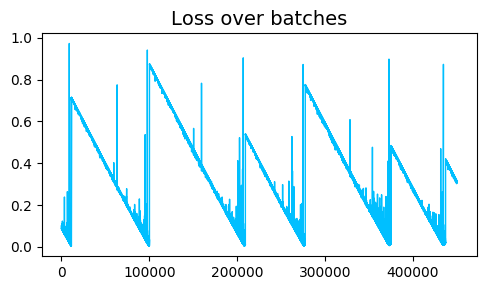

saving model...
Processing chunk 1550/2936...
Processing chunk 1600/2936...
Processing chunk 1650/2936...
Processing chunk 1700/2936...
Processing chunk 1750/2936...
Chunk no. 1750 
Duration of chunk: 1.79010


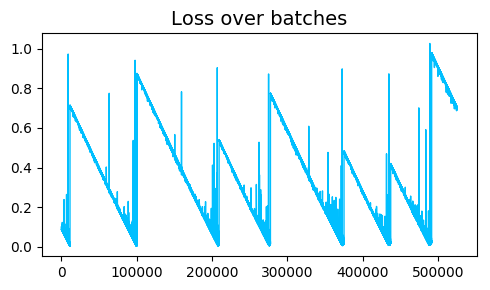

saving model...
Processing chunk 1800/2936...
Processing chunk 1850/2936...
Processing chunk 1900/2936...
Processing chunk 1950/2936...
Processing chunk 2000/2936...
Chunk no. 2000 
Duration of chunk: 1.82259


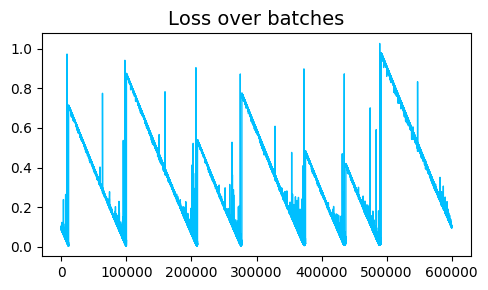

saving model...
Processing chunk 2050/2936...
Processing chunk 2100/2936...
Processing chunk 2150/2936...
Processing chunk 2200/2936...
Processing chunk 2250/2936...
Chunk no. 2250 
Duration of chunk: 1.83232


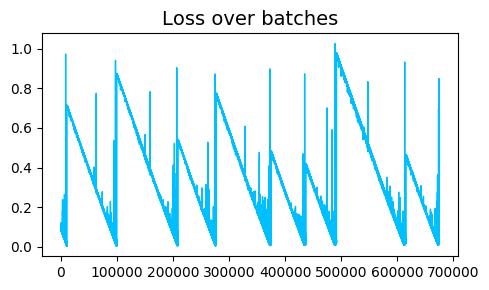

saving model...
Processing chunk 2300/2936...
Processing chunk 2350/2936...
Processing chunk 2400/2936...
Processing chunk 2450/2936...
Processing chunk 2500/2936...
Chunk no. 2500 
Duration of chunk: 1.82867


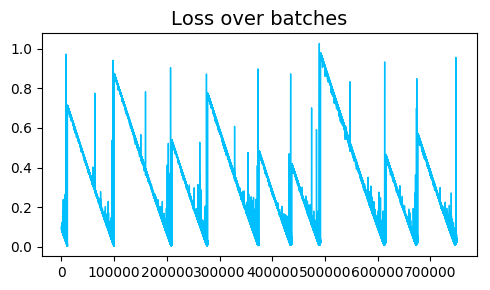

saving model...
Processing chunk 2550/2936...
Processing chunk 2600/2936...
Processing chunk 2650/2936...
Processing chunk 2700/2936...
Processing chunk 2750/2936...
Chunk no. 2750 
Duration of chunk: 1.83665


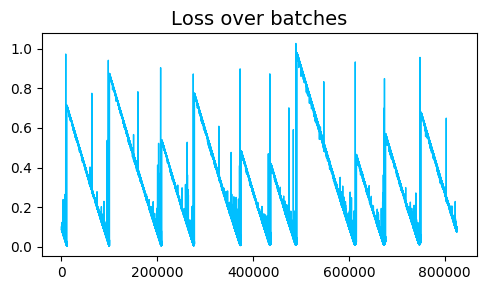

saving model...
Processing chunk 2800/2936...
Processing chunk 2850/2936...
Processing chunk 2900/2936...


In [0]:
# Train model
deep_GRU = build_GRU_model()
# deep_GRU.load_weights()

train_model(deep_GRU, start_point=0)

In [0]:
deep_GRU.save('final_GRU_model.h5')
files.download('/content/final_GRU_model.h5')  # from colab to browser download

## Predict time to failure on validation sets
This section, in order to match the kaggle datasets, predicts the **mean absolute error** between the real and predicted time to failure.  For a frame of reference, the top score on kaggle as of this submission is a MAE of about 1.5.

In [0]:
def predict_y(model, just_test=False):
  df = pd.read_csv(
      PROCESS_PATH_TR,
#       chunksize=CHUNK_SIZE,      
      skiprows=[TRAIN_SIZE],    
      # Valsize = 180_000_000, for size constraints only take 5% of values
      nrows=int(VAL_SIZE*0.05), 
  )
  
  X = df.iloc[:, :-1].values
  if not(just_test):
    y = df.iloc[:, -1].values
               
    # reshape to batch_size, n_steps, n_inputs
    X = np.reshape(X, (X.shape[0], X.shape[1], 1)) 
    y_pred = model.predict(X)
      
  return y, y_pred.reshape(-1)

In [0]:
y_val, y_pred = predict_y(deep_GRU)

In [0]:
a = scaler.inverse_transform(
    np.column_stack((np.zeros(len(y_val)), y_val)))
b = scaler.inverse_transform(
    np.column_stack((np.zeros(len(y_pred)), y_pred)))

y = a[:,1]
y_p = b[:,1]

In [31]:
MAE = mean_absolute_error(y, y_p)
print(
    'The mean absolute error between the real and predicted time to failure is '
    , MAE
)

The mean absolute error between the real and predicted time to failure is  4.431460333009036


In [0]:
def plot_overlayed_ttf(ttf, ttf_pred, title="TTF and predicited TTF"):
    fig, ax1 = plt.subplots(figsize=(12, 4))
    plt.title(title,fontdict=label_font)
    plt.plot(ttf, color='deepskyblue', linewidth=1)
    ax1.set_ylabel('Time to failure',fontdict=label_font)    
    ax1.set_xlabel('Batch #',fontdict=label_font)    
    plt.plot(ttf_pred, 's', color='orange', markersize=0.2, alpha=0.2)
    plt.legend(['ttf'], loc=2)
    plt.grid(False)
    plt.tight_layout()

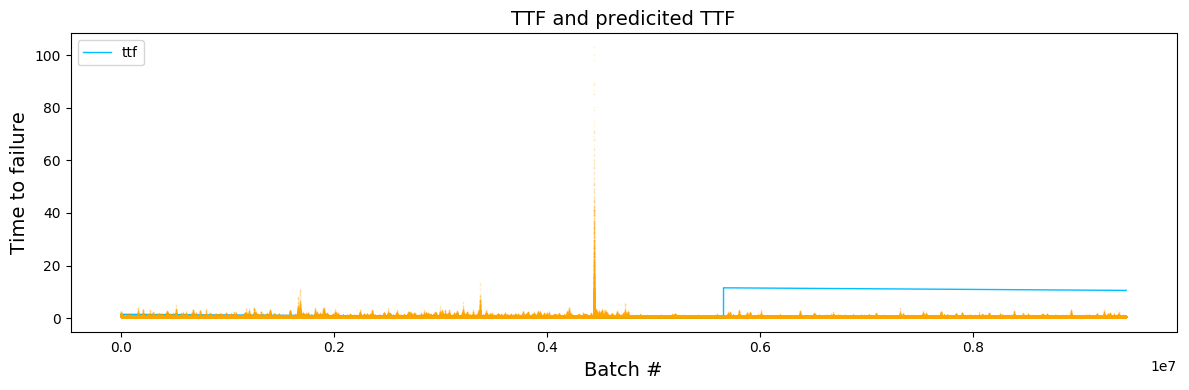

In [38]:
plot_overlayed_ttf(y, y_p)